Authors: Joshua Driscol, Dennis Hartmann <br/>
Date: 04.03.2019 <br/>
Description: Program to compute linear trends of GISSTemp Global Temperature Record. <br/>

*** Homework instructions: ***
Compute trends and uncertainties to see how sensitive trends are to starting and ending dates.

If you are curious, the data for this assignment was retrieved from [here](https://data.giss.nasa.gov/gistemp/).

### Data Cleaning

In [1]:
#data imports
import numpy as np
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt
%matplotlib inline

from process_gssi_global_temp import *

In [2]:
#provide file path, in this case just the name of the file
#filename = 'GISSTEMP_SEASONS_2019.txt'
filename = 'GLB.Ts.csv'

# name colors here
deeppink= '#FF1493'

#set significance level for analysis
sig_level = 0.975
sig_level_string = '95%'

In [3]:
#read in data to dataframe, skip header row
df = pd.read_csv(filename, header=1)

#clean data
df = clean(df)

/home/jakidxav/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


Now our data is processed and cleaned, we can begin our analysis here. But first, let's take a look at our dataset. We have a column that holds the years 1800-2018 inclusive. We also have columns for every month of the year, which hold a temperature in degrees Celsius during the year. </br>

Additionally, we have two different annual average columns (although for the purposes of this Notebook I recommend using 'J-D'), and seasonal average columns.

In [4]:
df.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,J-D,D-N,DJF,MAM,JJA,SON
0,1880,-0.81,-0.40,-0.47,-0.66,-0.36,-0.48,-0.47,0.08,-0.49,-0.66,-0.50,-0.52,-0.48,NaN,NaN,-0.49,-0.29,-0.55
1,1881,-0.79,-0.61,-0.36,-0.25,-0.02,-1.10,-0.52,-0.23,-0.32,-0.46,-0.55,-0.13,-0.45,-0.48,-0.64,-0.21,-0.62,-0.44
2,1882,0.13,-0.10,-0.07,-0.57,-0.36,-1.01,-0.70,-0.10,-0.06,-0.29,-0.38,-0.66,-0.35,-0.30,-0.04,-0.33,-0.60,-0.24
3,1883,-0.66,-0.93,-0.44,-0.29,-0.33,0.46,-0.01,-0.15,-0.44,-0.55,-0.68,-0.39,-0.37,-0.39,-0.75,-0.35,0.10,-0.56
4,1884,-0.62,-0.35,-0.40,-0.94,-1.20,-0.83,-0.86,0.14,-0.38,-0.78,-0.83,-1.01,-0.67,-0.62,-0.45,-0.85,-0.52,-0.66


### Data Analysis and Plotting

We are going to calculate the trend for different starting and ending times of this data. This is a linear regression of the form $y = mx + b$. </br>

Below is an example of what you will asked to do. You can see that by using different starting or ending dates, the slope of the trend changes. Not only that, but the sensitivity of our trend line changes. The sensitivity corresponds to confidence limits that we can place on the slope and intercept of our regression fit. In our case, we have done this by running a t-test at the 95\% confidence level.</br>

DOF stands for "degrees of freedom". We need to calculate this for our trend line because not every data point (year) in our sample is independent. If we did not do this calculation, we would be overestimating the amount of years we should use in our significance test. If $N$ is the number of years we have in a given sample, we can estimate the degrees of freedom as $N * \frac{1 - autocorrelation}{1 + autocorrelation}$.

<img src='example_trends.png'>

### Now it is your turn! Change the start and end years below and re-run the plotting method to see how the trend line changes. You should also feel free to change the column in question

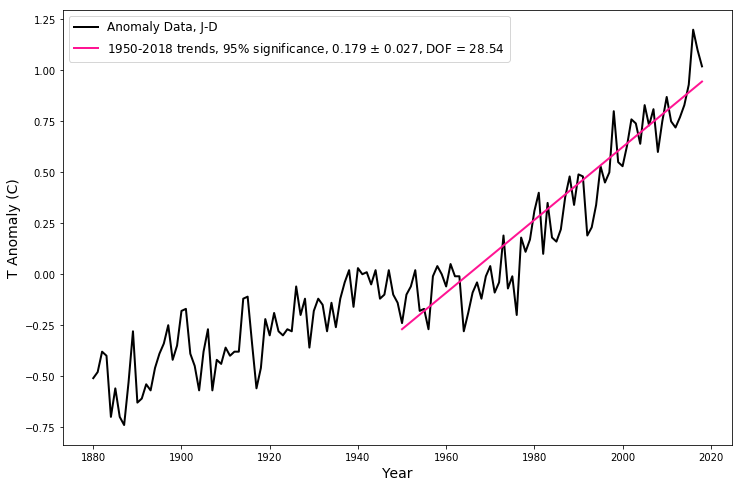

In [5]:
#TO-DO: change starting and ending years, as well as 
#       the column name here to be plotted here
start_year = 1950
end_year = 2018
column_name = 'J-D'

plot(start_year, end_year, df, column_name, deeppink, sig_level_string)